<a href="https://colab.research.google.com/github/PerifanosPrometheus/GiorgioDiSalvo/blob/master/Latent_sparse_positive_definite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#! /usr/bin/env python3
import numpy as np
from numpy.random import normal, poisson
import argparse
from collections import Counter
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import scale
from scipy.stats import chi2, norm
from sklearn.metrics import adjusted_rand_score as ari
!pip install graspologic
import graspologic
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.cluster import AutoGMMCluster
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial

In [2]:
#Code provided by Passino et al.
## Takes a vector and returns its spherical coordinates
def cart_to_sphere(x):
    ## theta_1
    q = np.arccos(x[1] / np.linalg.norm(x[:2]))
    sphere_coord = [q] if x[0] >= 0 else [2*np.pi - q]
    ## Loop for theta_2, ..., theta_m-1
    for j in range(2,len(x)):
      sphere_coord += [2 * np.arccos(x[j] / np.linalg.norm(x[:(j+1)]))]
    ## Return the result in a numpy array
    return np.array(sphere_coord)

## Takes a matrix and returns the spherical coordinates obtained along the given axis
def theta_transform(X,axis=1):
    ## Apply the function theta_transform along the axis
    return np.apply_along_axis(func1d=cart_to_sphere, axis=axis, arr=X)

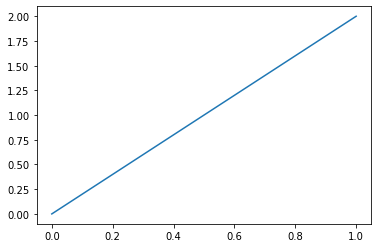

In [41]:
def beta_pdf(x,a,b):
  return ((gamma(a+b))/(gamma(a)*gamma(b)))*(x**(a-1))*((1-x)**(b-1))
x = np.array(range(0,101))/100
a = 2
b = 1


beta_pdf = np.apply_along_axis(lambda inp: beta_pdf(inp, a, b), axis=0, arr=x)
plt.plot(x, beta_pdf)
plt.show()

Text(0.5, 1.0, 'Degree correction parameters histogram')

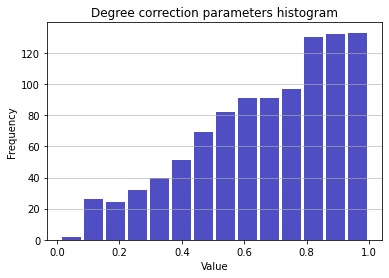

In [42]:
n = 1000

a = 2
b = 1

rho = np.random.beta(a=2,b=1,size=n)

plt.hist(x=rho, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Degree correction parameters histogram')

In [53]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_[0], gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [92]:
r"$\mathbf{X}_"+str(0) + "$"

'$\\mathbf{X}_0$'

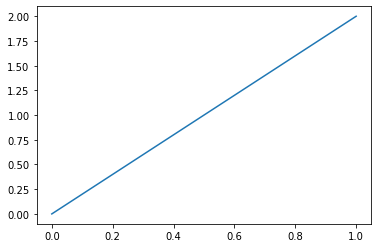

(-0.009473592264061893,
 1.0109639435740345,
 -0.7444250474116381,
 0.759624889358413)

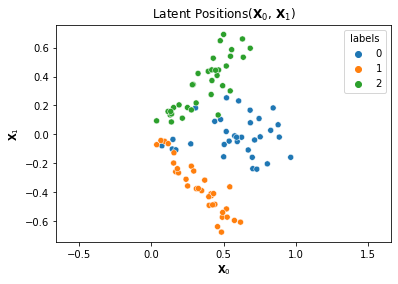

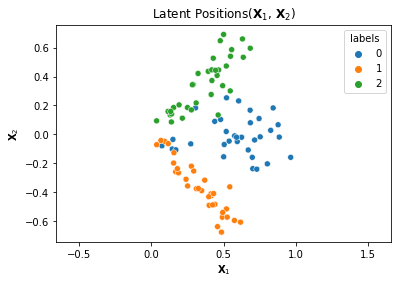

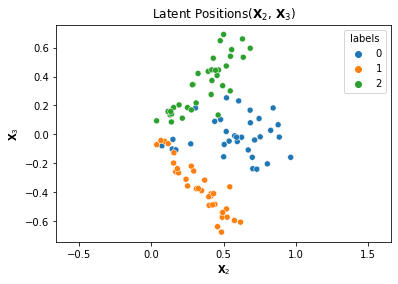

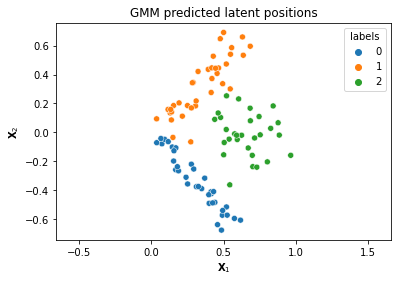

In [95]:
## Arguments
n = 100
#M_sim = 25 Use 25 to produce plot for experiment
M_sim = 1 # used to have some quick results to plot 
K = 3

s=0

a = 2
b = 1

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []


#plot distribution of degree correction parameters for beta
def beta_pdf(x,a,b):
  return ((gamma(a+b))/(gamma(a)*gamma(b)))*(x**(a-1))*((1-x)**(b-1))
x = np.array(range(0,101))/100
beta_pdf = np.apply_along_axis(lambda inp: beta_pdf(inp, a, b), axis=0, arr=x)
plt.plot(x, beta_pdf)
plt.show()

B = np.tril(np.random.uniform(size=(K,K)))
B += np.tril(B,k=-1).T

rho = np.random.beta(a=a,b=b,size=n)
if s == 1:
  plt.hist(x=rho, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Degree correction parameters histogram')

  
## Construct the adjacency matrix
A = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
        A[i,j] = edge
        A[j,i] = edge

if s == 1:
      plt.hist(x=rho, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
      plt.grid(axis='y', alpha=0.75)
      plt.xlabel('Value')
      plt.ylabel('Frequency')
      plt.title('Degree correction parameters histogram')

## Obtain the embeddings
ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
X = ase.fit_transform(A)

#removes latent positions made up only by zeros
idx_zerorows = np.where(~X.any(axis=1))
X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
zz = np.delete(z, idx_zerorows, 0) 

#M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
M = AutoGMMCluster(min_components=2, max_components=7)
M.fit(X, y=zz)

zz_hat = M.model_.predict(X)

for i in range(X.shape[1]):
  fig, ax = plt.subplots()
  xlabel = r"$\mathbf{X}_"+str(i) + "$"
  ylabel = r"$\mathbf{X}_"+str(i+1) + "$"
  x_hist = {xlabel: X[:, 0], ylabel: X[:, 1], 'labels': zz}
  x_hist = pd.DataFrame(data=x_hist)
  sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
  ax.set(xlabel=xlabel, ylabel=ylabel)
  ax.set_title(r"Latent Positions(" + xlabel + ", "+ ylabel + ")")
  ax.axis('equal')

fig, ax = plt.subplots()
x_hist = {r"$\mathbf{X}_0$": X[:, 0], r"$\mathbf{X}_1$": X[:, 1], 'labels': zz_hat}
x_hist = pd.DataFrame(data=x_hist)
#sns.color_palette("tab10")
sns.scatterplot(data=x_hist, x=r"$\mathbf{X}_0$",y = r"$\mathbf{X}_1$", hue="labels", palette= "tab10",ax = ax)
ax.set(xlabel=r"$\mathbf{X}_1$", ylabel=r"$\mathbf{X}_2$")
ax.set_title("GMM predicted latent positions")
ax.axis('equal')

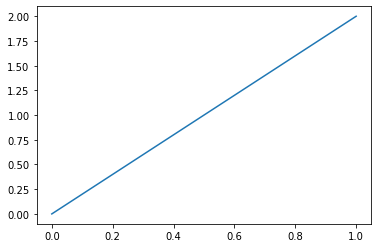

0


In [ ]:
## Arguments
n = 1000
#M_sim = 25 Use 25 to produce plot for experiment
M_sim = 2 # used to have some quick results to plot 
K = 3

a = 2
b = 1

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

sparse_scaler = 10


#plot distribution of degree correction parameters for beta
def beta_pdf(x,a,b):
  return ((gamma(a+b))/(gamma(a)*gamma(b)))*(x**(a-1))*((1-x)**(b-1))
x = np.array(range(0,101))/100
beta_pdf = np.apply_along_axis(lambda inp: beta_pdf(inp, a, b), axis=0, arr=x)
plt.plot(x, beta_pdf)
plt.show()

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.vstack(([0.8, 0.7, 0.45],
                   [0.6, 0.5, 0.1],
                   [0.15, 0.2, 0.3]))

    B = B / sparse_scaler

    rho = np.random.beta(a=a,b=b,size=n)
    if s == 1:
      plt.hist(x=rho, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
      plt.grid(axis='y', alpha=0.75)
      plt.xlabel('Value')
      plt.ylabel('Frequency')
      plt.title('Degree correction parameters histogram')


    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    if s ==1:
      for i in range(X.shape[1]):
        fig, ax = plt.subplots()
        xlabel = r"$\mathbf{X}_"+str(i) + "$"
        ylabel = r"$\mathbf{X}_"+str(i+1) + "$"
        x_hist = {xlabel: X[:, 0], ylabel: X[:, 1], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
        ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.set_title(r"Latent Positions(" + xlabel + ", "+ ylabel + ")")
        ax.axis('equal')

    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          X_norm = normalize(X)
          if s ==1:
            for i in range(X_norm.shape[1]):
              fig, ax = plt.subplots()
              xlabel = r"$\bar{\mathbf{X}_"+str(i) + "}$"
              ylabel = r"$\bar{\mathbf{X}_"+str(i+1) + "}$"
              x_hist = {xlabel: X_norm[:, 0], ylabel: X_norm[:, 1], 'labels': zz}
              x_hist = pd.DataFrame(data=x_hist)
              sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
              ax.set(xlabel=xlabel, ylabel=ylabel)
              ax.set_title(r"Latent Positions(" + xlabel + ", "+ ylabel + ")")
              ax.axis('equal')
          M.fit(X_norm, y=zz)
          if s ==1:
            zz_hat = M.model_.predict(X_norm)
            for i in range(X_norm.shape[1]):
              fig, ax = plt.subplots()
              xlabel = r"$\bar{\mathbf{X}_"+str(i) + "}$"
              ylabel = r"$\bar{\mathbf{X}_"+str(i+1) + "}$"
              x_hist = {xlabel: X_norm[:, 0], ylabel: X_norm[:, 1], 'labels': zz_hat}
              x_hist = pd.DataFrame(data=x_hist)
              sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
              ax.set(xlabel=xlabel, ylabel=ylabel)
              ax.set_title(r"GMM predictions on Latent Positions(" + xlabel + ", "+ ylabel + ") using Projections on unit circle")
              ax.axis('equal')
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          X_theta = theta_transform(X)
          if s ==1:
            for i in range(X_theta.shape[1]):
              fig, ax = plt.subplots()
              xlabel = r"$\Theta_"+str(i) + "$"
              ylabel = r"$\Theta_"+str(i+1) + "$"
              x_hist = {xlabel: X_theta[:, 0], ylabel: X_theta[:, 1], 'labels': zz}
              x_hist = pd.DataFrame(data=x_hist)
              sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
              ax.set(xlabel=xlabel, ylabel=ylabel)
              ax.set_title(r"Latent Positions(" + xlabel + ", "+ ylabel + ")")
              ax.axis('equal')
          M.fit(X_theta, y=zz)
          if s ==1:
            zz_hat = M.model_.predict(X_theta)
            for i in range(X_theta.shape[1]):
              fig, ax = plt.subplots()
              xlabel = r"$\Theta_"+str(i) + "$"
              ylabel = r"$\Theta_"+str(i+1) + "$"
              x_hist = {xlabel: X_theta[:, 0], ylabel: X_theta[:, 1], 'labels': zz_hat}
              x_hist = pd.DataFrame(data=x_hist)
              sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
              ax.set(xlabel=xlabel, ylabel=ylabel)
              ax.set_title(r"GMM predictions on Latent Positions(" + xlabel + ", "+ ylabel + ") using Spherical coordinates")
              ax.axis('equal')
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else:
          if s ==1:
            for i in range(X.shape[1]):
              fig, ax = plt.subplots()
              xlabel = r"$\mathbf{X}_"+str(i) + "$"
              ylabel = r"$\mathbf{X}_"+str(i+1) + "$"
              x_hist = {xlabel: X[:, 0], ylabel: X[:, 1], 'labels': zz}
              x_hist = pd.DataFrame(data=x_hist)
              sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
              ax.set(xlabel=xlabel, ylabel=ylabel)
              ax.set_title(r"Latent Positions(" + xlabel + ", "+ ylabel + ")")
              ax.axis('equal') 
          M.fit(X, y=zz)
          if s ==1:
            zz_hat = M.model_.predict(X)
            for i in range(X.shape[1]):
              fig, ax = plt.subplots()
              xlabel = r"$\mathbf{X}_"+str(i) + "$"
              ylabel = r"$\mathbf{X}_"+str(i+1) + "$"
              x_hist = {xlabel: X[:, 0], ylabel: X[:, 1], 'labels': zz_hat}
              x_hist = pd.DataFrame(data=x_hist)
              sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax)
              ax.set(xlabel=xlabel, ylabel=ylabel)
              ax.set_title(r"GMM predictions on Latent Positions(" + xlabel + ", "+ ylabel + "), using No transformation of coordinates")
              ax.axis('equal') 
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)